# Multi-label X-Ray Image Classification

In this notebook, x-ray photographs of COVID-19, Healthy, and Viral Pneumonia patients are used to train various Deep Learning classifiers to predict each of these conditions based on only such x-ray photographs.

The data for this project was taken from the publicly available COVID-19 Radiography Database (https://www.kaggle.com/tawsifurrahman/covid19-radiography-database). These data were provided by Tawsifur Rahman at the University of Dhaka.

The data include 219 COVID-19 positive images, 1341 normal images and 1345 viral pneumonia images. From these totals, 80% of the images were selected for training and 20% were used for testing.

Classifiers from the sklearn library have been adopted. A non-exhaustive parameter optimization scheme was conducted for each classifier using GridSearchCV (also from sklearn). The best version of each classifier was trained and tested. To analyze the performance, several Yellowbrick visualization tools were employed. Additionally, several sklearn metrics were included to quantitatively characterize the performance of each model. 

## Load the relevant libraries

In [1]:
#Basic
import numpy as np
import cv2
import scipy
import os
from keras.utils import np_utils
import random
import seaborn as sns

#Pre-processing
import glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from time import time

#Parameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import cross_val_score

#Classifiers
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Visualizers
%matplotlib inline
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

#shush the warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\Oswaldo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Oswaldo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Oswaldo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Oswaldo\anaconda3\lib\site-packages\tensorflow\python\framework\d

## Establish a base directory

In [2]:
BASE_DIR = 'C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/'

## Import and plot COVID-19 positive images

In [3]:
import glob
imagePatches = glob.glob(BASE_DIR +'dataset/Train/Class1/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (1).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (10).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (100).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (101).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (102).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (103).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (104).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (105).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (106).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class1\COVID-19 (107).png


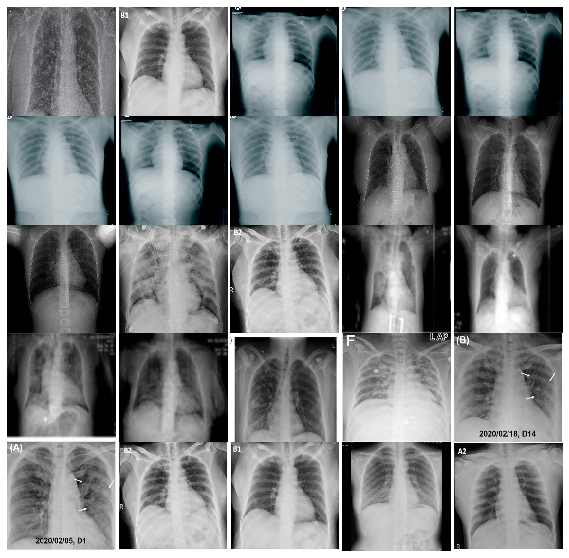

In [4]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (224, 224)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

## Import and plot Healthy images

In [5]:
imagePatches2 = glob.glob(BASE_DIR +'dataset/Train/Class2/*.png', recursive=True)
for filename in imagePatches2[0:10]:
    print(filename)

C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (10).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (100).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1000).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1001).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1002).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1003).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1004).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1005).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class2\NORMAL (1006).png


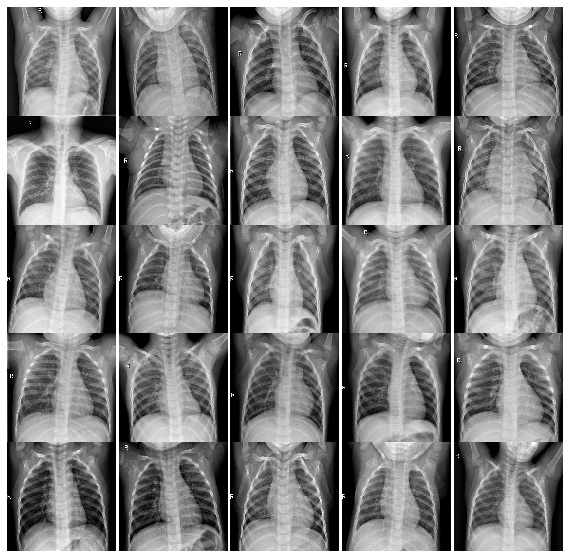

In [6]:
# Plot Multiple Images
bunchOfImages2 = imagePatches2
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages2[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (224, 224)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

## Import and plot Viral Pneumonia positive images

In [7]:
imagePatches3 = glob.glob(BASE_DIR +'dataset/Train/Class3/*.png', recursive=True)
for filename in imagePatches3[0:10]:
    print(filename)

C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (10).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (100).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1000).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1001).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1002).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1003).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1004).png
C:/Users/Oswaldo/Google Drive/Colab Notebooks/Final_Project/dataset/Train/Class3\Viral Pneumonia (1005).png
C:/Users/Oswaldo/Google Drive/Cola

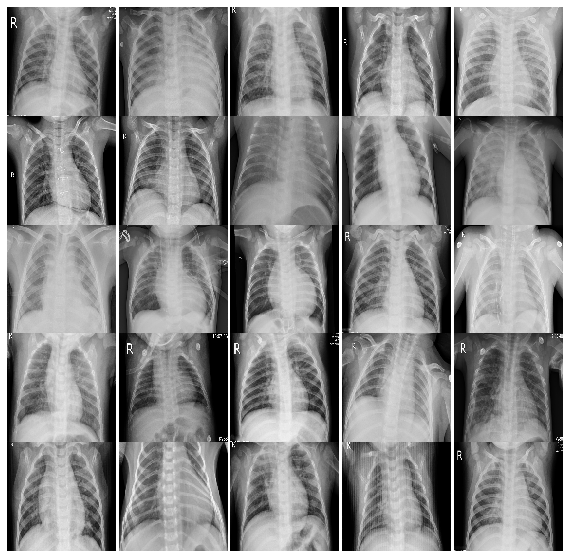

In [8]:
# Plot Multiple Images
bunchOfImages3 = imagePatches3
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages3[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (224, 224)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

## Load data and assign labels

In [9]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for rayx_type in os.listdir(folder):
        if not rayx_type.startswith('.'):
            if rayx_type in ['Class1']:
                label = '0'
            else:
                if rayx_type in ['Class2']:
                    label = '1'
                else:
                    label ='2'
            for image_filename in os.listdir(folder + rayx_type):
                img_file = cv2.imread(folder + rayx_type + '/' + image_filename, 0)
                if img_file is not None:
                    # Downsample the image to 224, 224, 3
                    image = cv2.resize(img_file, (224, 224))
                    img_arr = np.asarray(image)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [10]:
#Define classes
classes = ["0","1","2"]

In [11]:
X_train, y_train = get_data(BASE_DIR + 'dataset/Train/')
X_test, y_test = get_data(BASE_DIR + 'dataset/Test/')

In [12]:
#Reshaping the 3D arrays of data to 2D

nsamples, nx, ny = X_train.shape
nsamples2, nx2, ny2 = X_test.shape
X_train_new = X_train.reshape((nsamples,nx*ny))
X_test = X_test.reshape((nsamples2,nx2*ny2))

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

### Here we introduce our matrices for parameter optimization of each classifier
Parameter optimization is automated using GridSearchCV

In [13]:
#Define the K-Nearest Neighbors parameter values to be tested for optimization

n_neighbors_range = np.linspace(3, 10, num = 8, dtype=int)

#Implement GridSearchCV for K-Nearest Neighbors

param_grid_KNN = dict(n_neighbors=n_neighbors_range)
grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_KNN, cv=5)
grid_KNN.fit(X_train_new, y_train)

print("The best KNN parameters are %s with a score of %0.2f"
      % (grid_KNN.best_params_, grid_KNN.best_score_))

#Store the best parameter values for use in K-Nearest Neighbors Model

n_neighbors_selected=grid_KNN.best_params_['n_neighbors']

The best KNN parameters are {'n_neighbors': 8} with a score of 0.89


In [14]:
#Define the Logistic Regression parameter values to be tested for optimization

C_LR_range = np.linspace(1, 10, num = 11, dtype=float)

#Implement GridSearchCV for Logistic Regression

param_grid_LR = dict(C=C_LR_range)
grid_LR = GridSearchCV(LogisticRegression(), param_grid=param_grid_LR, cv=5)
grid_LR.fit(X_train_new, y_train)

print("The best LR parameters are %s with a score of %0.2f"
      % (grid_LR.best_params_, grid_LR.best_score_))

#Store the best parameter values for use in Logistic Regression Model

C_LR_selected=grid_LR.best_params_['C']

The best LR parameters are {'C': 1.0} with a score of 0.92


In [15]:
#Define the Decision Tree parameter values to be tested for optimization

min_samples_leaf_range = np.linspace(1, 5, num = 6, dtype=int)

#Implement GridSearchCV for Decision Tree

param_grid_DT = dict(min_samples_leaf=min_samples_leaf_range)
grid_DT = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_DT, cv=5)
grid_DT.fit(X_train_new, y_train)

print("The best DT parameters are %s with a score of %0.2f"
      % (grid_DT.best_params_, grid_DT.best_score_))

#Store the best parameter values for use in Decision Tree Model

min_samples_leaf_selected=grid_DT.best_params_['min_samples_leaf']

The best DT parameters are {'min_samples_leaf': 3} with a score of 0.79


In [16]:
#Define the Random Forest parameter values to be tested for optimization

n_estimators_range = np.linspace(1, 5, num = 6, dtype=int)

#Implement GridSearchCV for Random Forest

param_grid_RF = dict(n_estimators=n_estimators_range)
grid_RF = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_RF, cv=5)
grid_RF.fit(X_train_new, y_train)

print("The best RF parameters are %s with a score of %0.2f"
      % (grid_RF.best_params_, grid_RF.best_score_))

#Store the best parameter values for use in Random Forest Model

n_estimators_selected=grid_RF.best_params_['n_estimators']

The best RF parameters are {'n_estimators': 5} with a score of 0.85


In [17]:
#Define the Support Vector Classifier parameter values to be tested for optimization

C_SVC_range = np.linspace(1, 100, num = 5, dtype=float)

gamma_SVC_range = np.linspace(1, 5, num = 5, dtype=float)

#Implement GridSearchCV for Support Vector Classifier

param_grid_SVC = dict(C=C_SVC_range, gamma=gamma_SVC_range)
grid_SVC = GridSearchCV(SVC(), param_grid=param_grid_SVC, cv=5)
grid_SVC.fit(X_train_new, y_train)

print("The best SVC parameters are %s with a score of %0.2f"
      % (grid_SVC.best_params_, grid_SVC.best_score_))

#Store the best parameter values for use in Support Vector Classifier Model

C_SVC_selected=grid_SVC.best_params_['C']
gamma_SVC_selected=grid_SVC.best_params_['gamma']

The best SVC parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.46


## Make a bundle of classifiers

In [18]:
# select classifiers 
classifiers=[
KNeighborsClassifier(n_neighbors = n_neighbors_selected),
LogisticRegression(C = C_LR_selected, random_state=0, multi_class='multinomial', solver='newton-cg'),
DecisionTreeClassifier(min_samples_leaf = min_samples_leaf_selected, random_state=0),
RandomForestClassifier(n_estimators=n_estimators_selected),
SVC(C = C_SVC_selected, gamma = gamma_SVC_selected),
MLPClassifier()]

## Define functions for the visualization tools

In [19]:
#Write function for class-centric metrics
# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        visualizer.fit(X_train_new, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        Class_report(name,classes)

#Class Prediction Error
def CPE_viz():    
    def CPE(model,classes):
        visualizer = ClassPredictionError(model, classes=classes)
        visualizer.fit(X_train_new, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CPE(name,classes)
        
#Confusion matrix
def CM_viz():    
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes,percent=True)
        visualizer.fit(X_train_new, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CM(name,classes)
        
#ROC-AUC
def ROC_viz():    
    def ROC(model,classes):
        visualizer = ROCAUC(model, classes=classes)
        visualizer.fit(X_train_new, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        ROC(name,classes)

#Precision Recall Curve
def PRC_viz():  
    def PRC(model,classes):
        visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
    fill_area=False, micro=False)
        visualizer.fit(X_train_new, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        PRC(name,classes)


## Define function for the aggregate metrics

In [20]:
# Write function for aggregate metrics
def classifier_metrics():    
    def metrics(model):
        #     model=model_name()
        model.fit(X_train_new, y_train)  # Fit the visualizer and the model
        y_pred = model.predict(X_test)
        try: 
            y_prob = model.predict_proba(X_test)
            log_metric = log_loss(y_test,y_prob)
        except:
            y_prob = "Not probablistic"
            log_metric = 0
        else:
            y_pred = model.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        c_k_s=cohen_kappa_score(y_test,y_pred)
        zero_met=zero_one_loss(y_test,y_pred)
        hl=hamming_loss(y_test,y_pred)
        mc=matthews_corrcoef(y_test,y_pred)
        print('cohen_kappa_score: {0:.3f}'.format(c_k_s))
        print('log_loss: {0:.3f}'.format(log_metric))
        print('zero_one_loss: {0:.3f}'.format(zero_met))
        print('hemming_loss: {0:.3f}'.format(hl))
        print('matthews_corrcoef: {0:.3f}'.format(mc))
    for name in classifiers:
        print (str(name))
        metrics(name)   
        
        
        
        print()
        print ("------------------------------------------------------")

## Visualize the results

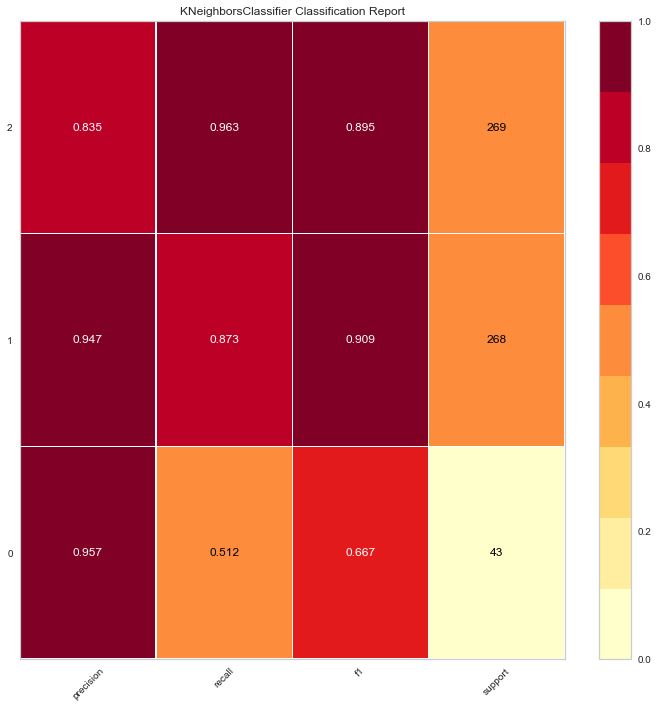

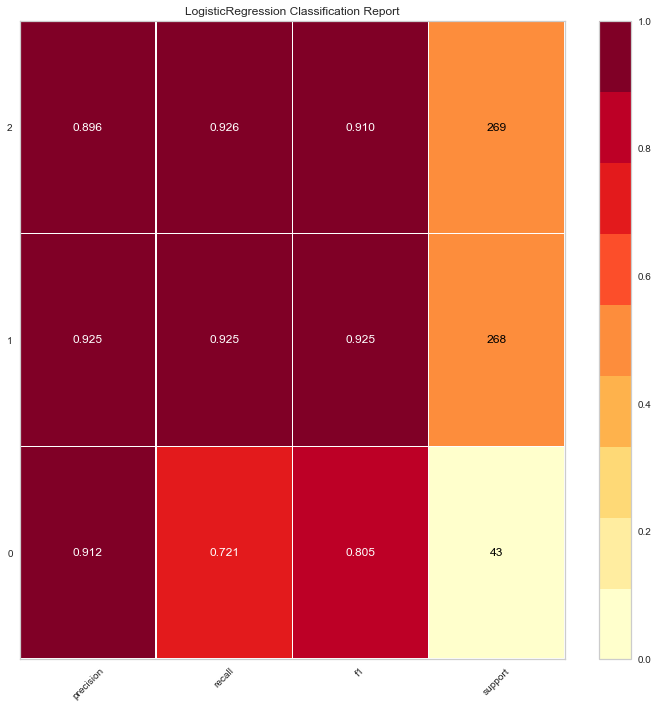

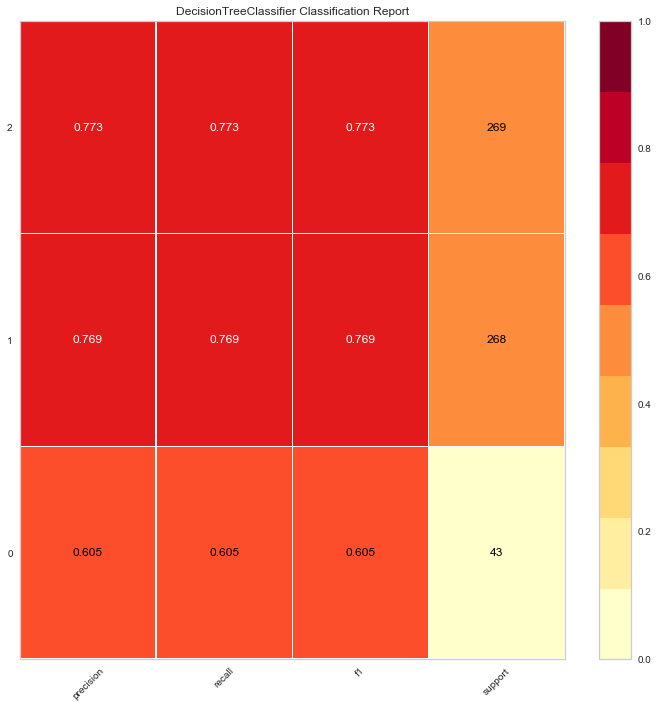

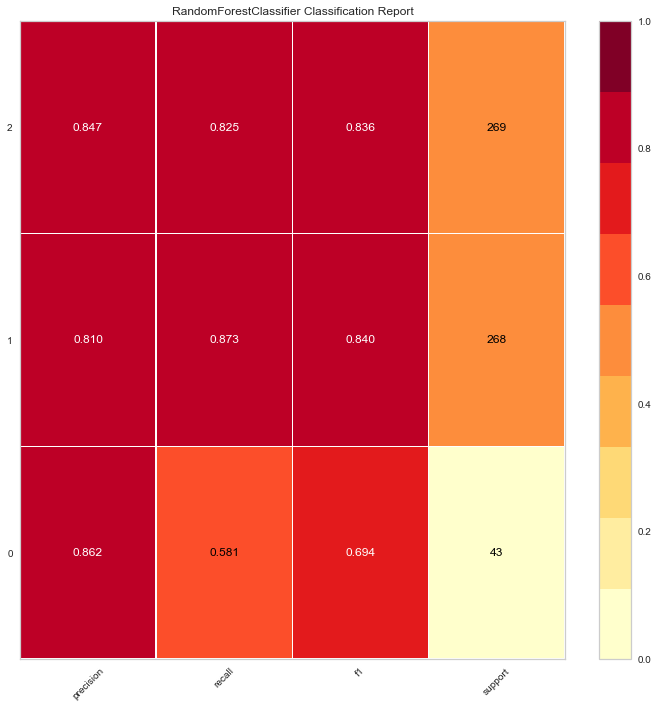

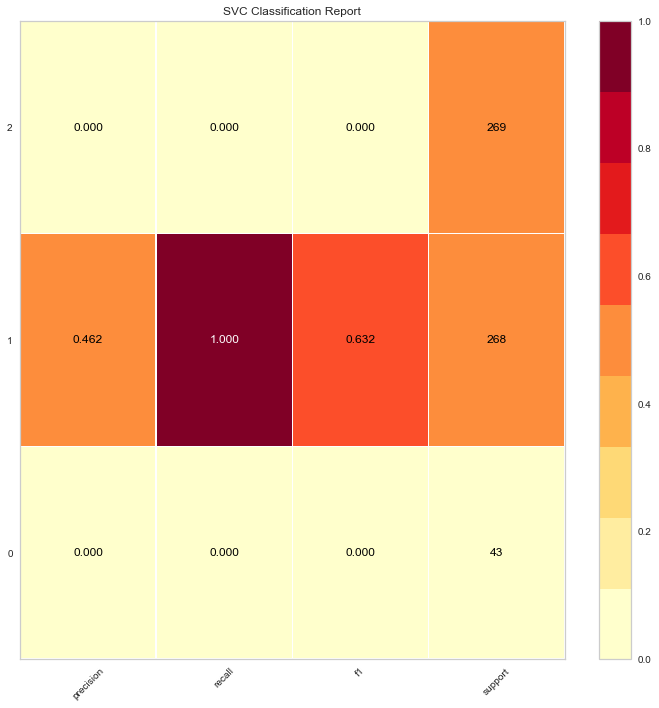

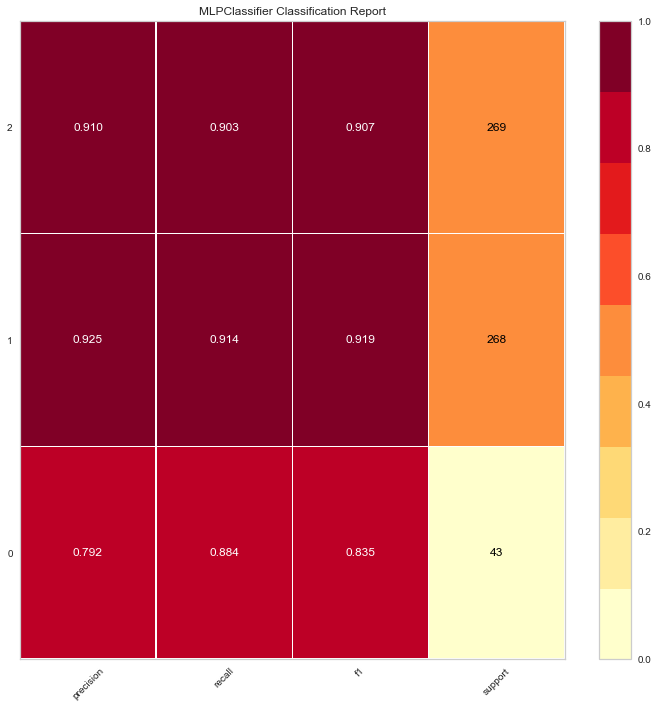

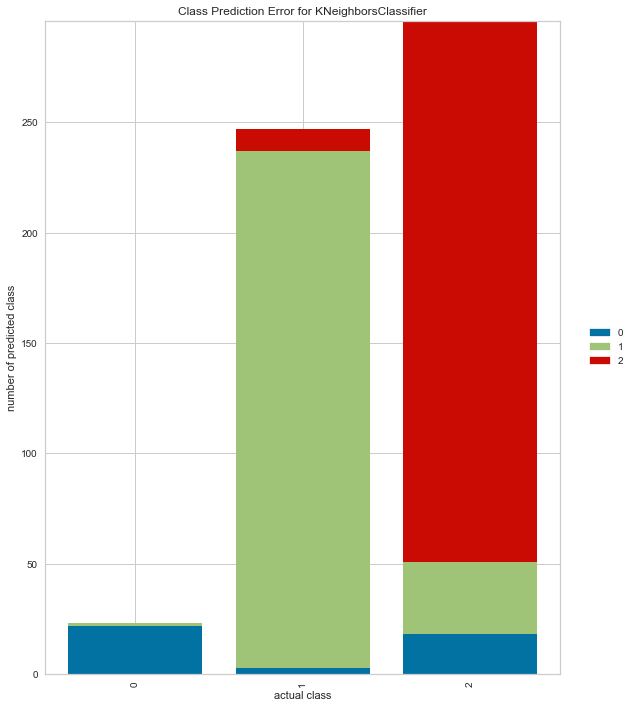

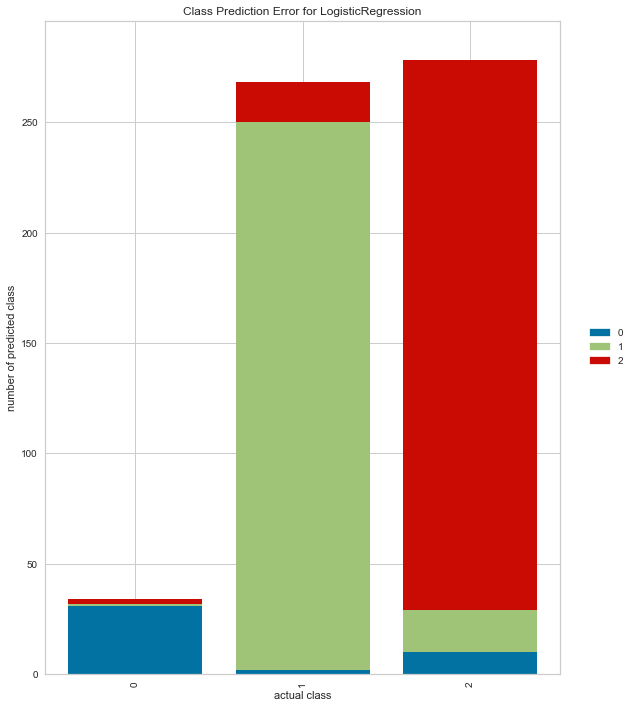

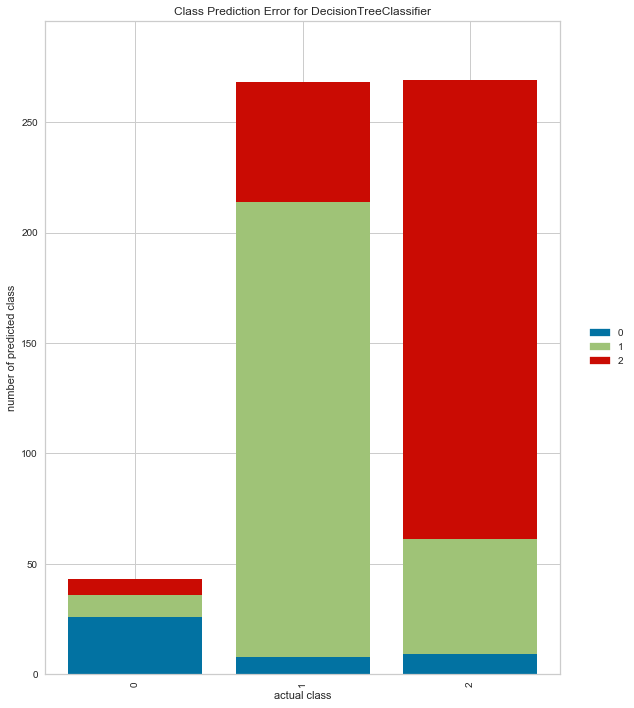

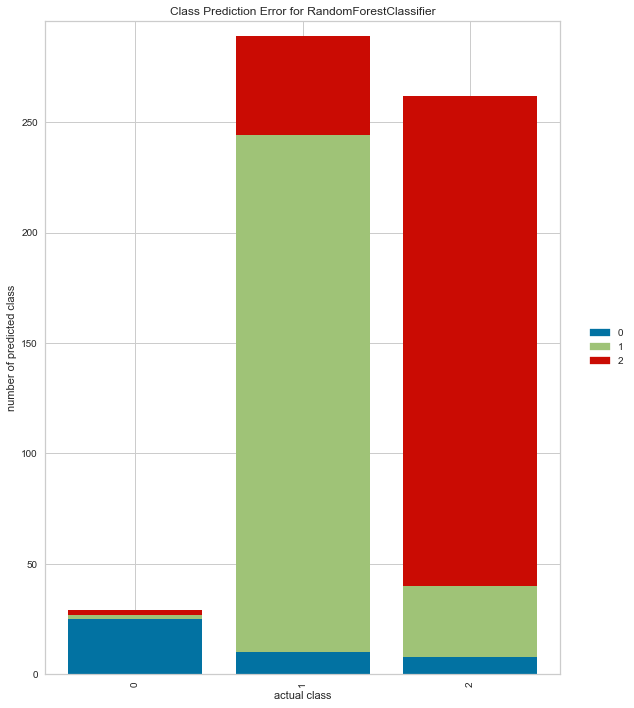

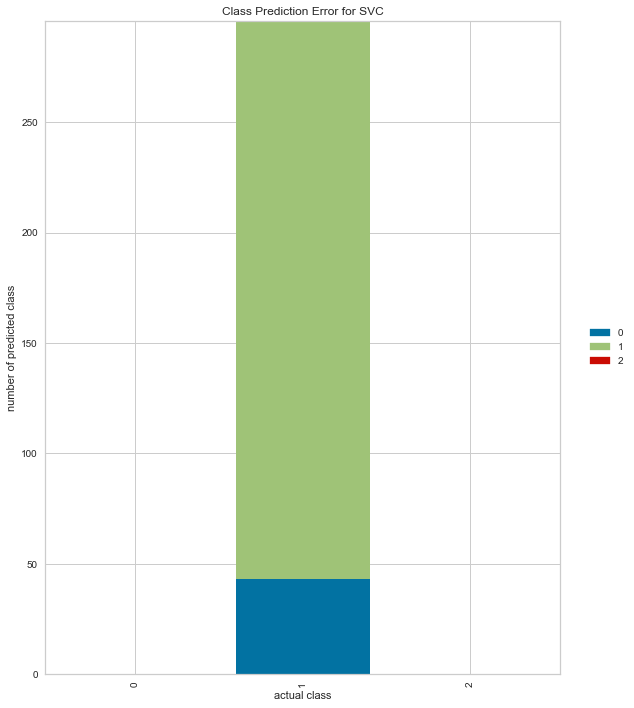

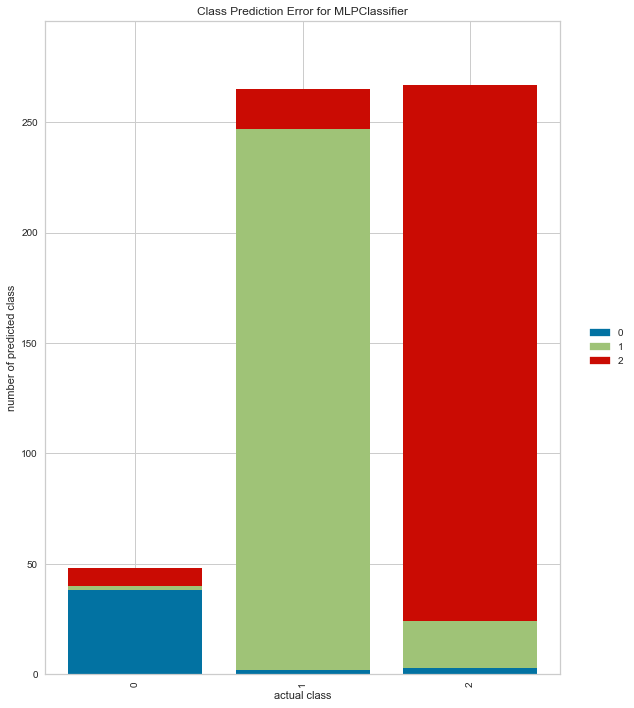

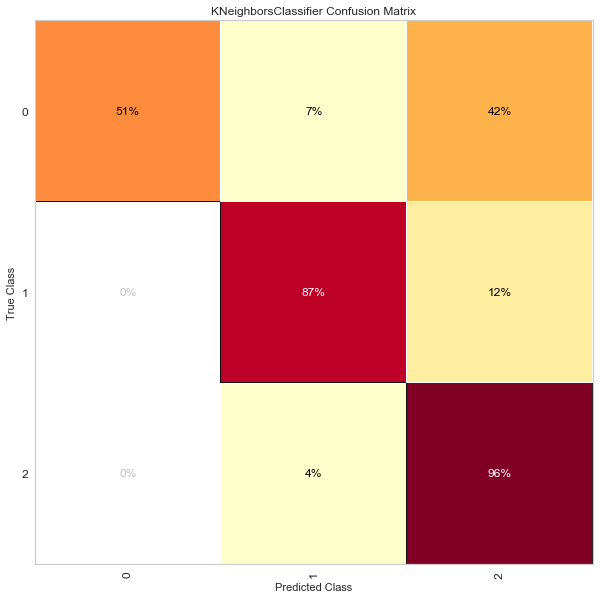

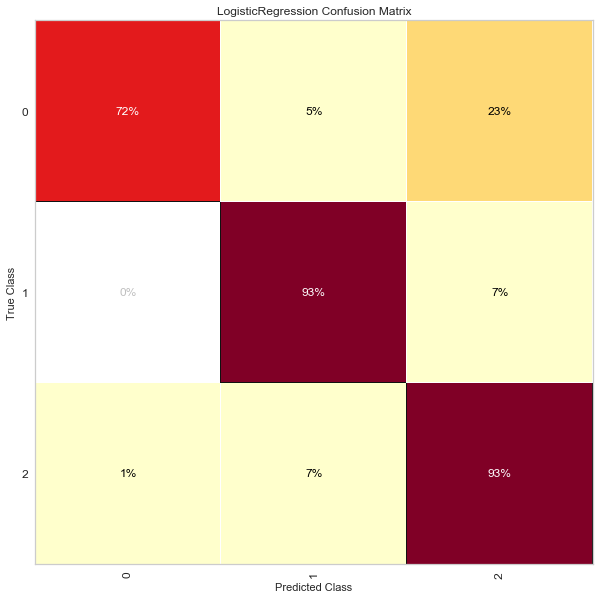

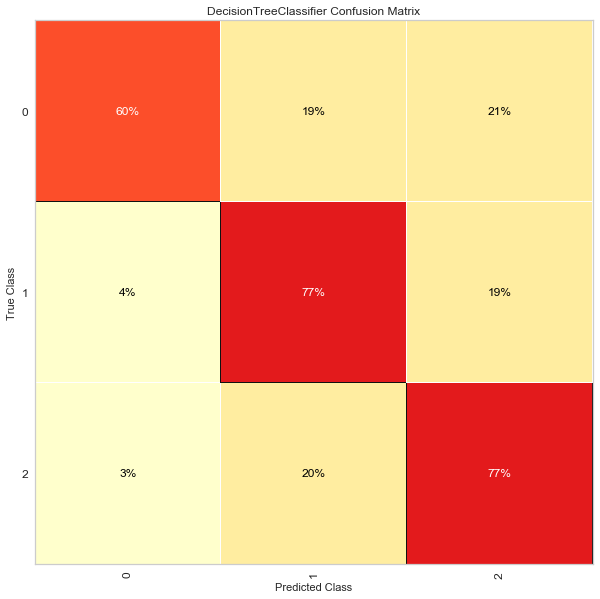

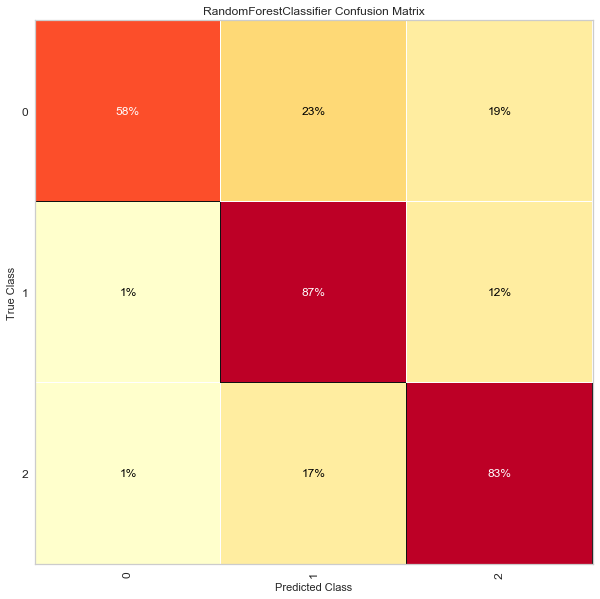

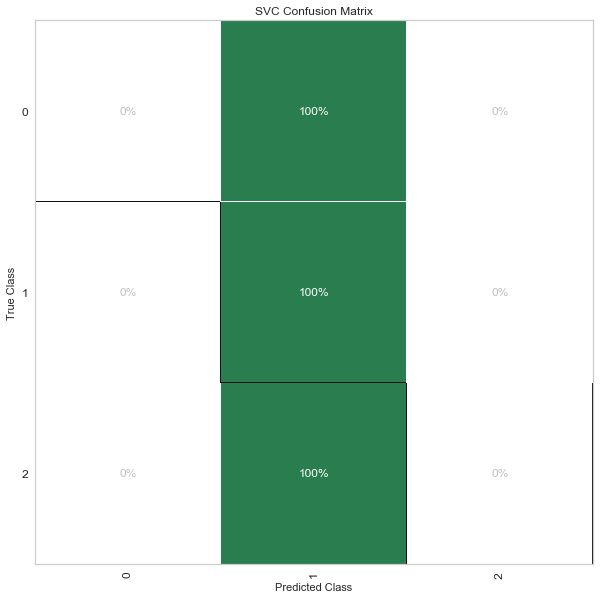

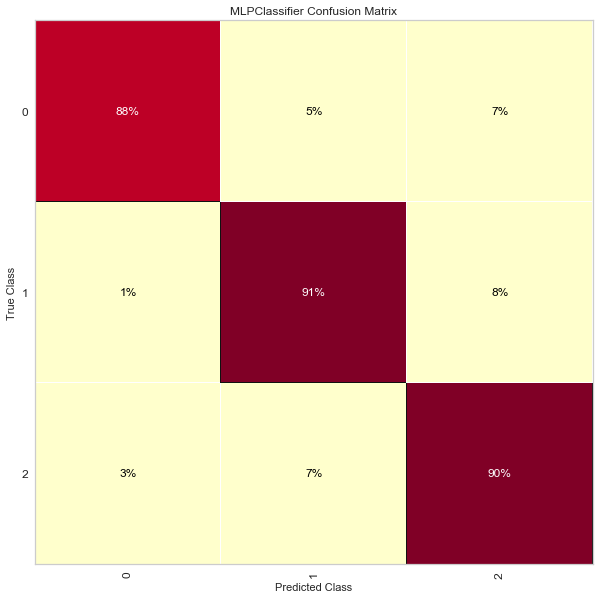

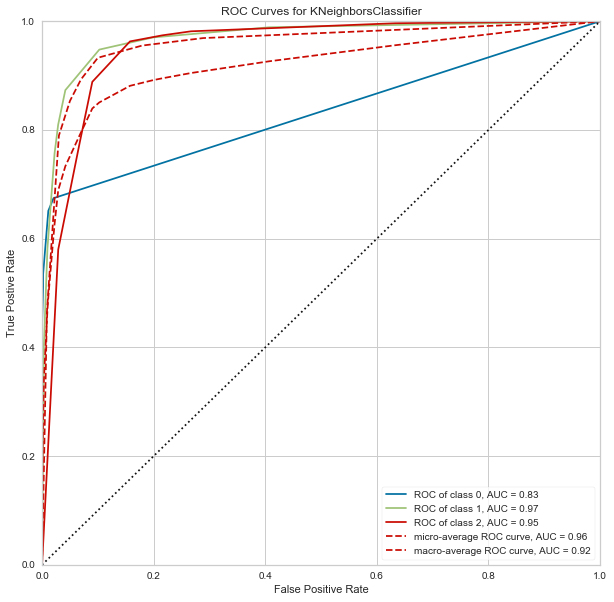

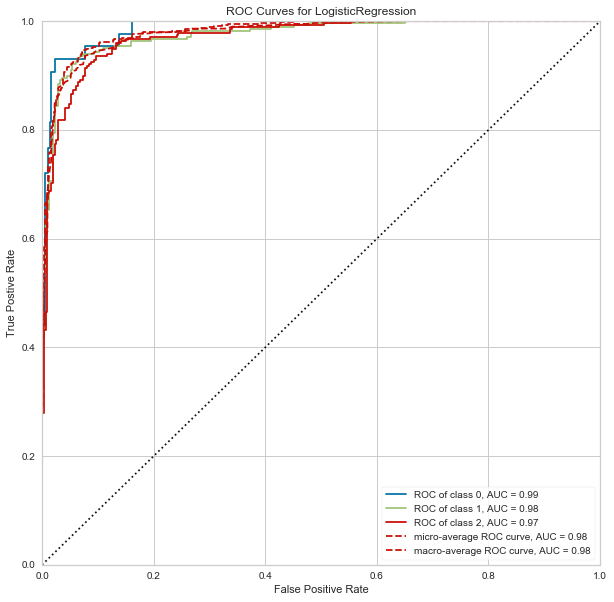

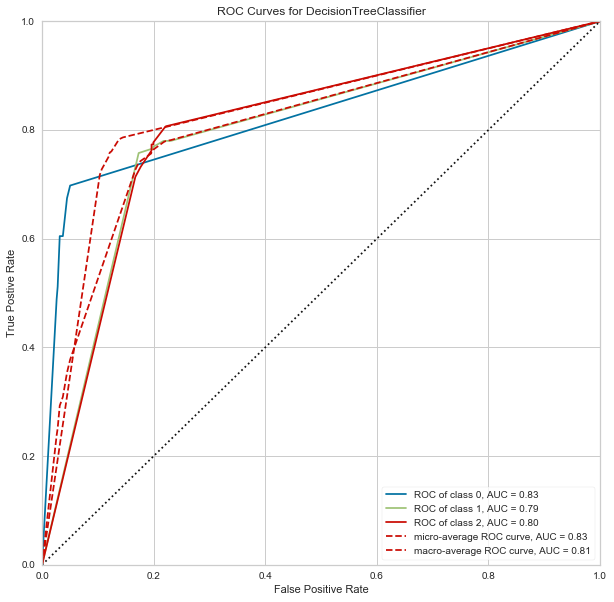

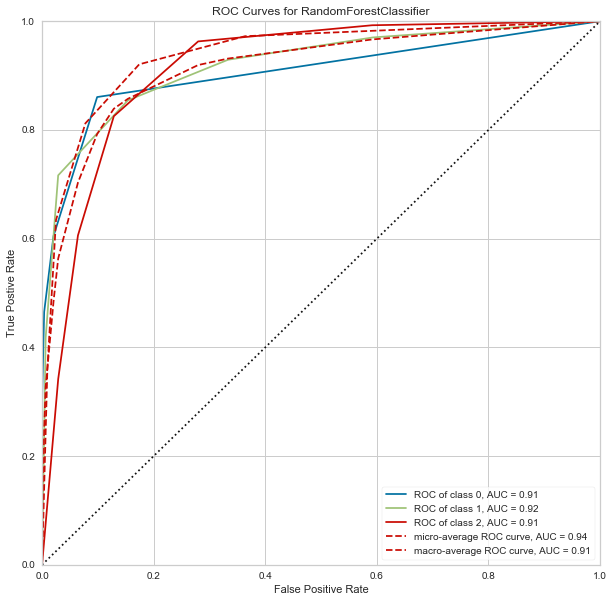

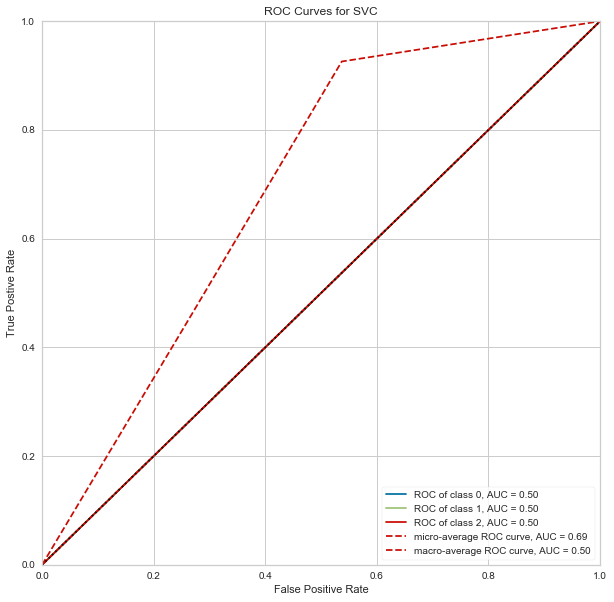

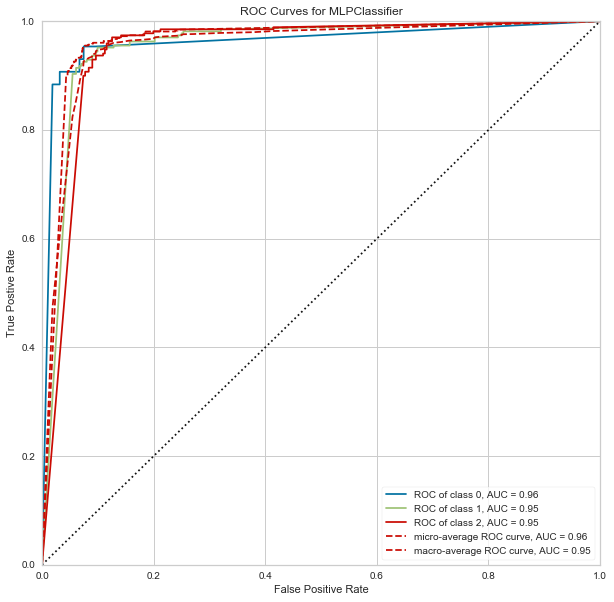

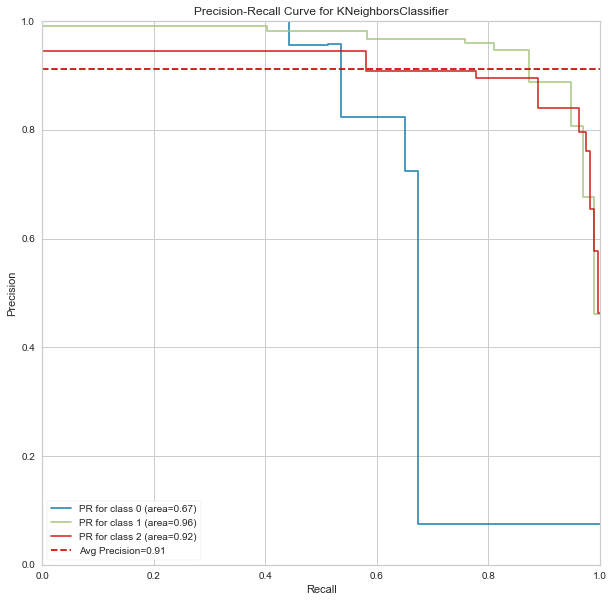

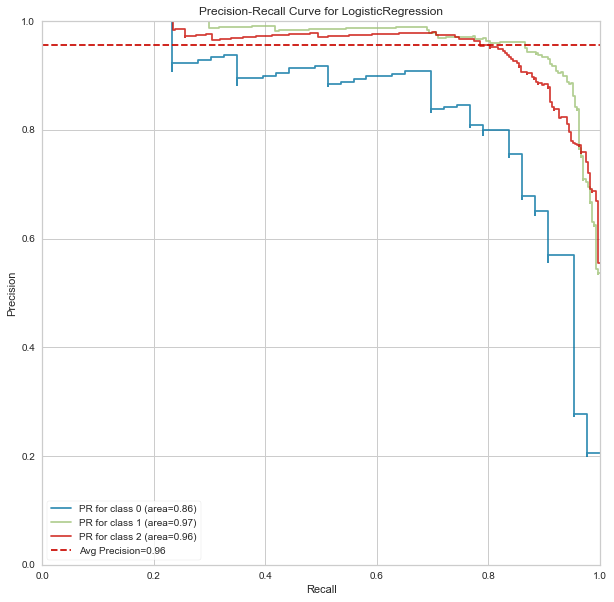

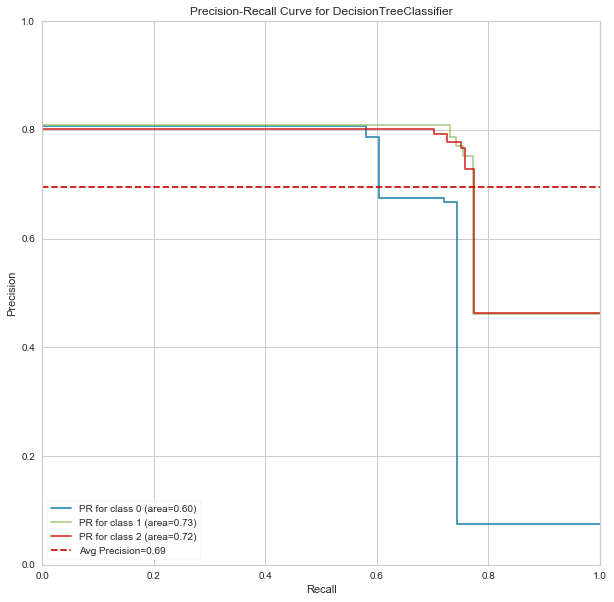

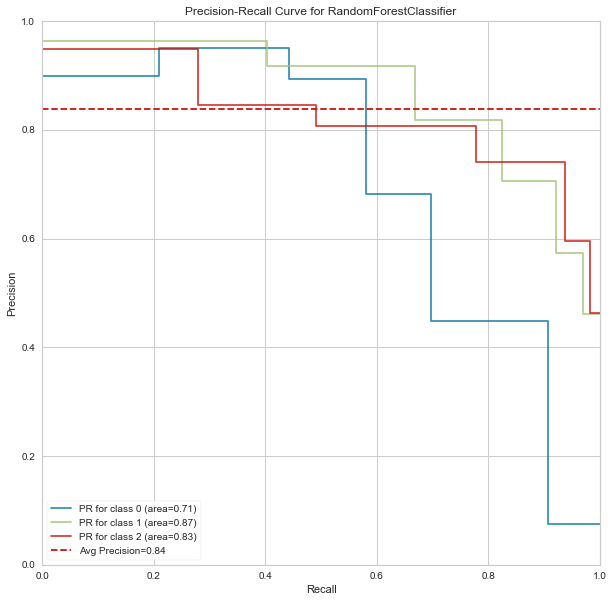

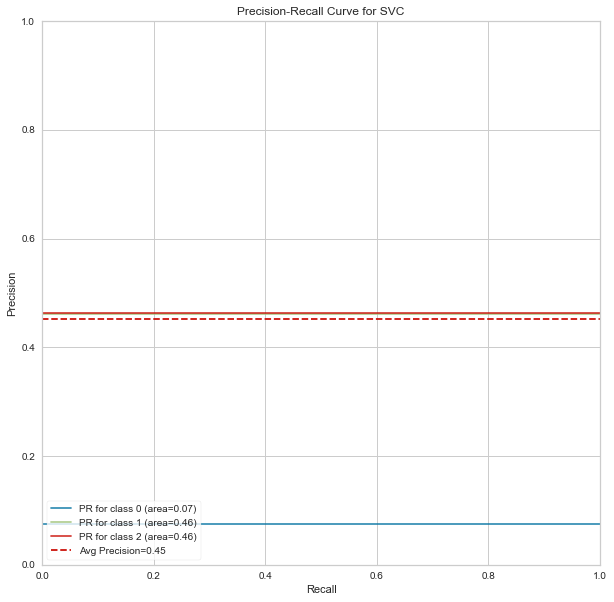

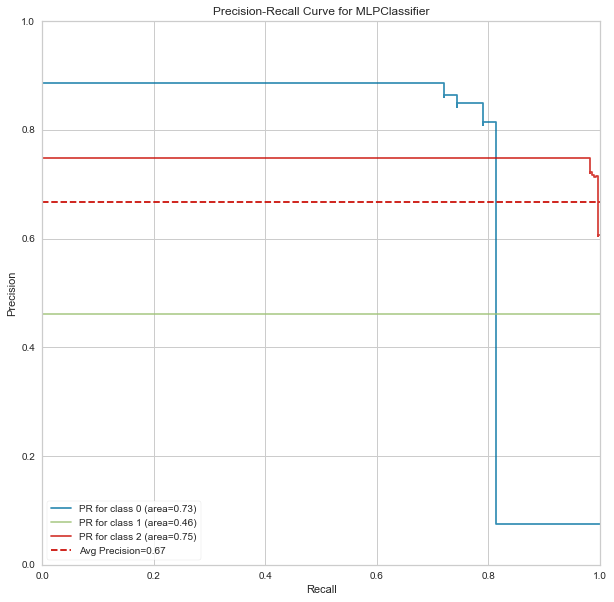

In [21]:
#Report the visualization
visualization =[CR_viz(),CPE_viz(),CM_viz(),ROC_viz(),PRC_viz()]

## Report the metrics

In [22]:
#Report the aggregate metrics  
classifier_metrics()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')
cohen_kappa_score: 0.797
log_loss: 1.293
zero_one_loss: 0.112
hemming_loss: 0.112
matthews_corrcoef: 0.803

------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
cohen_kappa_score: 0.840
log_loss: 0.911
zero_one_loss: 0.090
hemming_loss: 0.090
matthews_corrcoef: 0.840

------------------------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,